In [73]:
#first cell for data cleaning

import pandas as pd
import numpy as np

df = pd.read_csv('Honors_Option_Data.csv') #data on arbitration eligible players from 2011-2025

keep_columns = ['Name', 'Shortened_name', 'Team', 'Birthdate', 'Year', 'YOS', 'PlayerOffer', 'TeamOffer', 'PrevSalary_updated', 
                'FinalSalary_Updated', 'WAR_prev', 'WAR_current', 'primary_position']

df_clean = df[keep_columns].copy()
df_clean = df_clean.replace(['Null', 'x'], np.nan)

df_clean = df_clean.iloc[:-594] #dropped final 594 rows because they are very incomplete as they were recently added 

#AI used to learn how to convert birth date's (currently listed as an integer in the format YYYYMMDD to an actual date
#Source: OpenAI. (2025). ChatGPT-5. Accessed from https://chatgpt.com/ on Nov 16, 2025
#Prompt: "How would I convert an integer representing a date as YYYYMMDD to only the year value in order to subtract it from current year"

df_clean['Birth_year'] = df_clean['Birthdate'].astype(str).str[:4].astype(int)
df_clean['Age'] = df_clean['Year'] - df_clean['Birth_year']

#AI used to learn how to convert salary numbers with commas (3,000,000) to integers (3000000)
#Source: OpenAI. (2025). ChatGPT-5. Accessed from https://chatgpt.com/ on Nov 16, 2025
#Prompt: "How would I convert a string value for salaries (3,000,000) to integers ; I have 3 rows with more two values listed one with parentheses
#since they make up a very small portion of the dataset how would I identify and drop those rows?"

df_clean = df_clean[~df_clean['FinalSalary_Updated'].astype(str).str.contains(r'\(')]
df_clean = df_clean[~df_clean['PrevSalary_updated'].astype(str).str.contains(r'\(')]
df_clean = df_clean[~df_clean['PlayerOffer'].astype(str).str.contains(r'\(')]
df_clean = df_clean[~df_clean['TeamOffer'].astype(str).str.contains(r'\(')]

df_clean['FinalSalary_Updated'] = df_clean['FinalSalary_Updated'].astype(str).str.replace(',', '').astype(float)
df_clean['PrevSalary_updated'] = df_clean['PrevSalary_updated'].astype(str).str.replace(',', '').astype(float)
df_clean['PlayerOffer'] = df_clean['PlayerOffer'].astype(str).str.replace(',', '').astype(float)
df_clean['TeamOffer'] = df_clean['TeamOffer'].astype(str).str.replace(',', '').astype(float)

df_clean['YOS'] = df_clean['YOS'].astype(str).str.replace(',', '.').astype(float)

In [74]:
#Checking for key factors in predicting Final Salary

import statsmodels.api as sm

model_FS = df_clean[['FinalSalary_Updated', 'PrevSalary_updated', 'WAR_current', 
                     'WAR_prev', 'Age', 'YOS']].dropna().astype(float)

x = model_FS[['PrevSalary_updated', 'WAR_current', 'WAR_prev', 'Age', 'YOS']]
x = sm.add_constant(x)
y = model_FS['FinalSalary_Updated']

Future_Salary_Model = sm.OLS(y, x).fit()
print(Future_Salary_Model.summary())

                             OLS Regression Results                            
Dep. Variable:     FinalSalary_Updated   R-squared:                       0.813
Model:                             OLS   Adj. R-squared:                  0.812
Method:                  Least Squares   F-statistic:                     1926.
Date:                 Mon, 17 Nov 2025   Prob (F-statistic):               0.00
Time:                         22:02:28   Log-Likelihood:                -34871.
No. Observations:                 2225   AIC:                         6.975e+04
Df Residuals:                     2219   BIC:                         6.979e+04
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -4.413e

In [75]:
x = model_FS[['PrevSalary_updated', 'WAR_prev', 'YOS']]
x = sm.add_constant(x)
y = model_FS['FinalSalary_Updated']

Future_Salary_Model = sm.OLS(y, x).fit()
print(Future_Salary_Model.summary())

                             OLS Regression Results                            
Dep. Variable:     FinalSalary_Updated   R-squared:                       0.806
Model:                             OLS   Adj. R-squared:                  0.806
Method:                  Least Squares   F-statistic:                     3074.
Date:                 Mon, 17 Nov 2025   Prob (F-statistic):               0.00
Time:                         22:02:29   Log-Likelihood:                -34911.
No. Observations:                 2225   AIC:                         6.983e+04
Df Residuals:                     2221   BIC:                         6.985e+04
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -1.822e

In [76]:
model_FS['PrevSalary_mil'] = model_FS['PrevSalary_updated'] / 1e6
model_FS['FinalSalary_mil'] = model_FS['FinalSalary_Updated'] / 1e6

x = model_FS[['PrevSalary_mil', 'WAR_prev', 'YOS']]
x = sm.add_constant(x)
y = model_FS['FinalSalary_mil']

Millions_Salary_Model = sm.OLS(y, x).fit()
print(Millions_Salary_Model.summary())

                            OLS Regression Results                            
Dep. Variable:        FinalSalary_mil   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     3074.
Date:                Mon, 17 Nov 2025   Prob (F-statistic):               0.00
Time:                        22:02:29   Log-Likelihood:                -4171.4
No. Observations:                2225   AIC:                             8351.
Df Residuals:                    2221   BIC:                             8374.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.1822      0.152     -1.

Text(0.5, 1.0, 'Actual vs Predicted Final Salary (millions)')

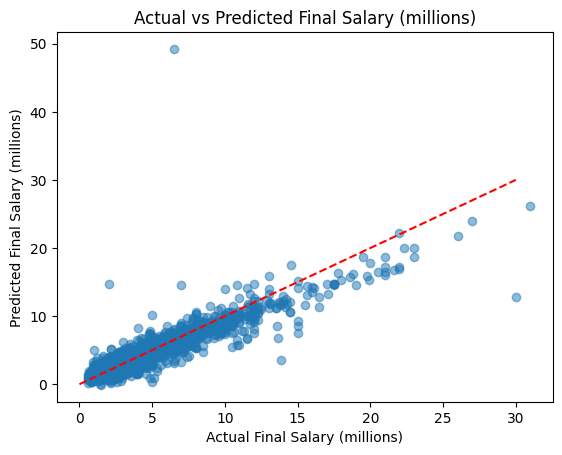

In [83]:
import matplotlib.pyplot as plt

predicted = Millions_Salary_Model.predict(x)

plt.scatter(model_FS['FinalSalary_mil'], predicted, alpha=0.5)
plt.plot([0, 30], [0, 30], color='red', linestyle='--')
plt.xlabel('Actual Final Salary (millions)')
plt.ylabel('Predicted Final Salary (millions)')
plt.title('Actual vs Predicted Final Salary (millions)')